La parte interesante de MESF es eliminar la autocorrelación implícita de los datos debido a la posición geográfica (en regresión lineal se supone que las observaciones son indepenientes). 

In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append(
    "/Users/mateo/Documents/Máster Big Data/TFM/codes/urbana-barcelona-master/src"
)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error

from libpysal.weights import Queen, KNN, Gabriel
import networkx as nx

from urbana.models.plot_predictions import PredictedAccuracy
from urbana.constants import DIR_REPO, DIR_DATA

In [5]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

YEAR = 2023  # ALLOWED_YEARS = [2017, 2018, 2023]
MONTH = 12

OUTPUT_WARNINGS = False
SAVE_FIGS = False
FIT_INTERCEPT = True

VARIABLE_TO_PREDICT = "Airbnb_Number"

# Number of selected variables in these categories
K_EDUCATION = 1
K_AGE = 2
K_NATIONALITY = 2
K_RENT = 1
K_POI = 10

In [6]:
if OUTPUT_WARNINGS is False:
    import warnings

    warnings.filterwarnings("ignore")

# Parameter Check

In [7]:
ALLOWED_YEARS = [2017, 2018, 2023]

if YEAR not in ALLOWED_YEARS:
    raise Exception("Please select a year within: {}".format(ALLOWED_YEARS))

if YEAR == 2018 and MONTH == 3:
    raise Exception(
        "Month 3 (March) is not available for 2018. Please choose a different month."
    )

In [8]:
# Create folders to store the data
DIR_VAR = DIR_DATA / "processed/{}".format(VARIABLE_TO_PREDICT)
DIR_MONTH = DIR_VAR / "{}_{:02d}".format(YEAR, MONTH)
DIR_SVR = DIR_MONTH / "05_svr"

if SAVE_FIGS:
    folder_list = [
        DIR_SVR,
        DIR_SVR / "coefficients",
    ]

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

In [9]:
PATH_TO_FILE = DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH)
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "00acquisition.ipynb" with the same date and "SAVE_DATA" set to True'
    )

In [10]:
PATH_TO_FILE = DIR_MONTH / "01_linear/coefficients.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "01linear.ipynb" with the same date and "SAVE_MODEL" set to True'
    )

# Initial visualizations

In [11]:
sect = pd.read_csv(
    DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH),
)

sect.set_index("Tag", inplace=True)

sect.drop(
    ["N_district", "N_neighbourhood", "N_section"],
    axis=1,
    inplace=True,
)
sect.drop(["Percentage_Age_25_39"], axis=1, inplace=True)  # Duplicate


sect.isnull().sum(axis=0).sort_values(ascending=False).head(10)

Airbnb_Location_Score             151
Airbnb_Price_Person               119
Airbnb_Price                      119
Rent_Area_Flats                    18
Rent_Price_Total_Flats             18
Rent_Price_Meter_Flats             18
Rent_Number_Flats                  10
Nationality_Venezuela               0
Nationality_Dominican_Republic      0
Nationality_Ecuador                 0
dtype: int64

In [12]:
geo_info = gpd.read_file(
    DIR_DATA / "interim/sections_geo.json",
)

geo_info.set_index("Tag", inplace=True)

geo_coefs = geo_info.copy()
geo_tvals = geo_info.copy()
geo_nans = geo_info.copy()

In [13]:
# y = np.array(sect[VARIABLE_TO_PREDICT]).reshape((-1, 1)).flatten()
y = sect[VARIABLE_TO_PREDICT]
X = sect.drop(
    [
        "Airbnb_Number",
        "Airbnb_Price",
        "Airbnb_Price_Person",
        "Airbnb_Location_Score",
    ],
    axis=1,
)

print(X.shape)

coords = np.column_stack(
    [geo_info["geometry"].centroid.x, geo_info["geometry"].centroid.y]
)

geo_info["centroid"] = geo_info["geometry"].centroid

(1068, 84)


In [14]:
geo_info[VARIABLE_TO_PREDICT] = sect[VARIABLE_TO_PREDICT]

id_max_airbnb = geo_info[VARIABLE_TO_PREDICT].idxmax()

print("Area with maximum value: " + str(id_max_airbnb))

Area with maximum value: 02_077


## Target variable

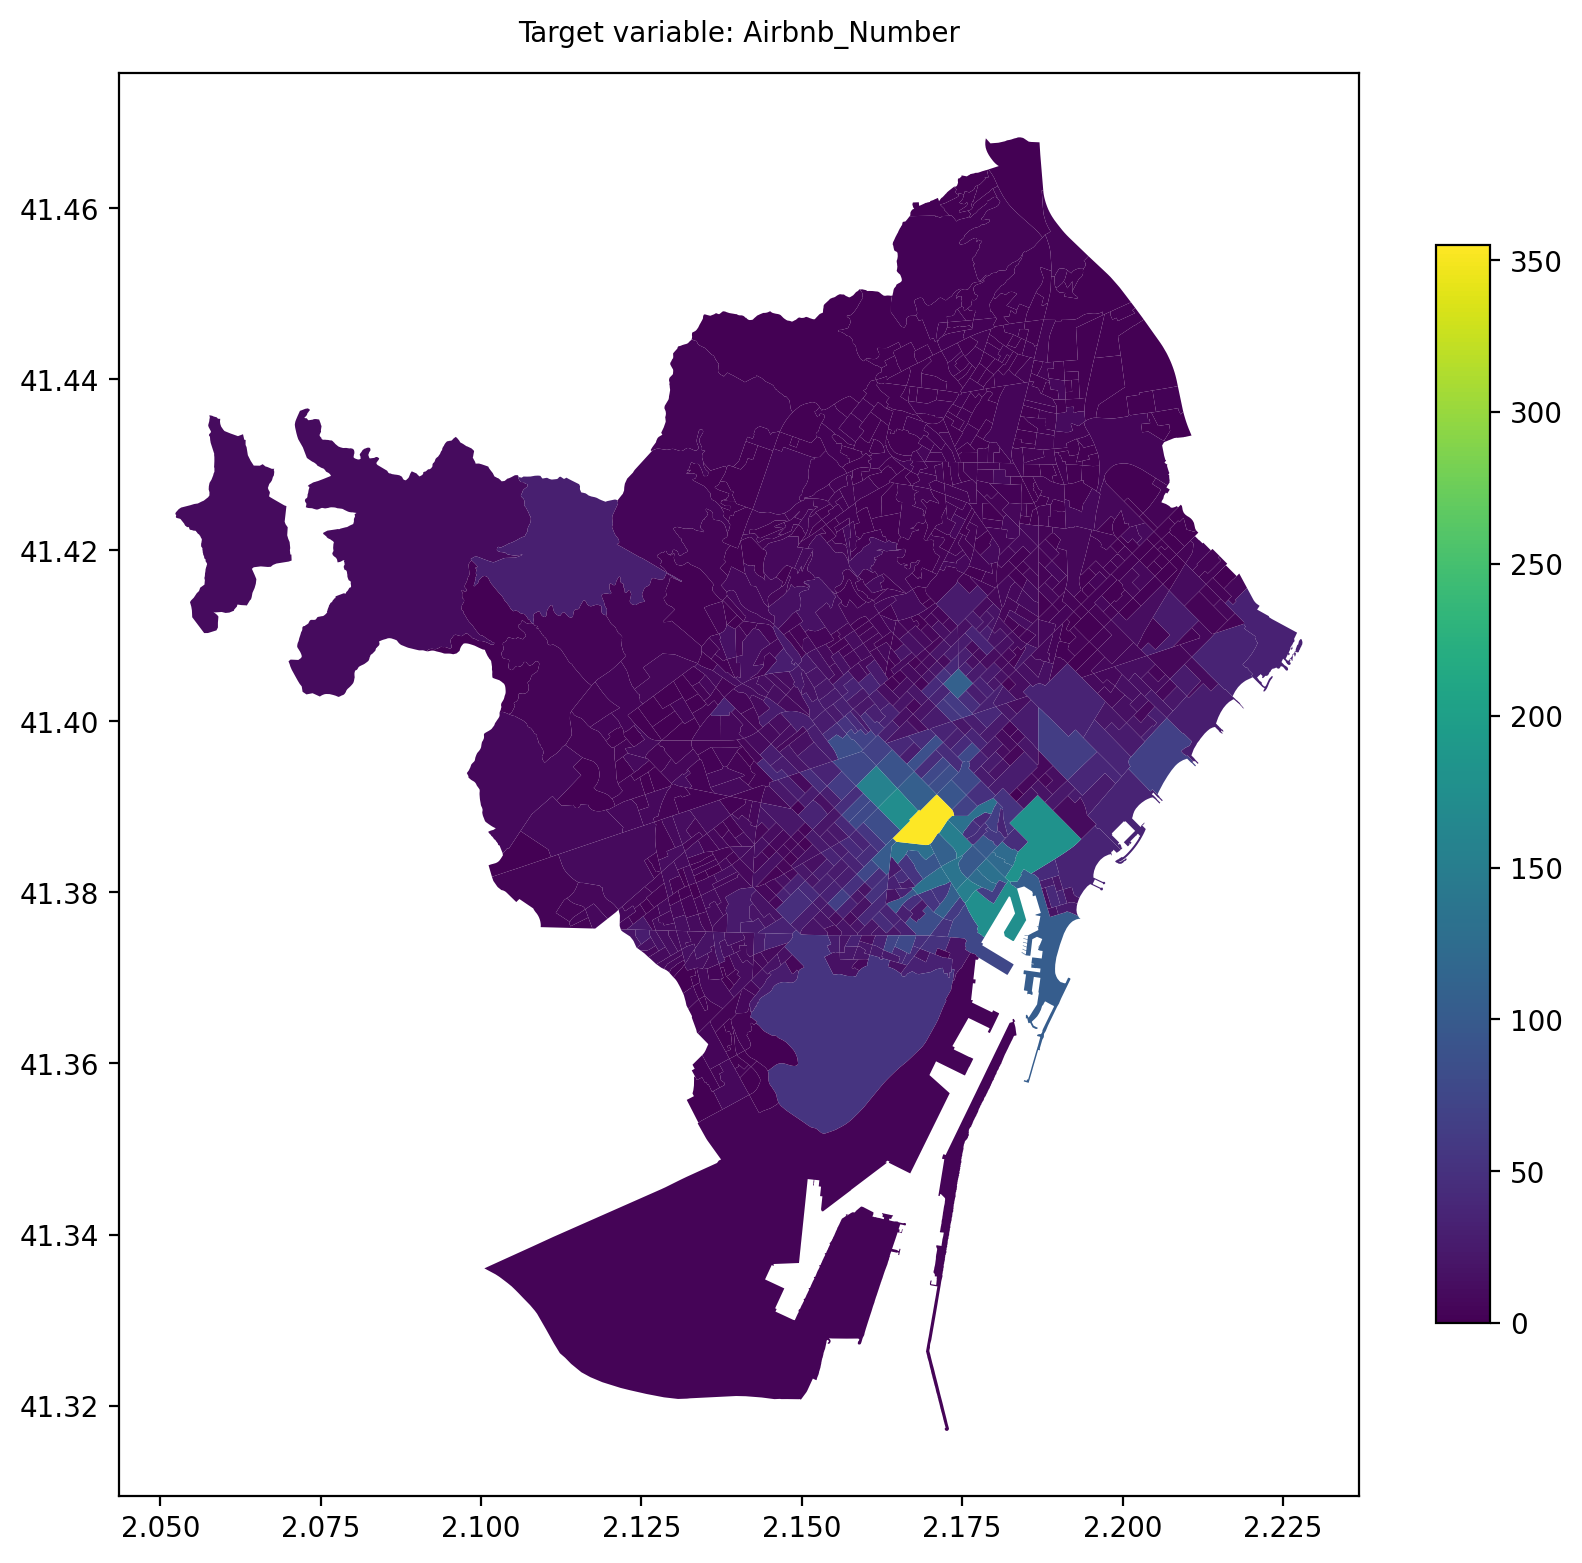

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

geo_info.plot(
    ax=ax,
    column=VARIABLE_TO_PREDICT,
    legend=True,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Target variable: " + str(VARIABLE_TO_PREDICT), fontsize=10, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_SVR / "target_variable.svg", format="svg")

plt.show()

This plot shows the geographical distribution of the number of Airbnbs in Barcelona. It can be seen that there is a high concentration in the city center, and that it is apparently reduced when increasing the distance. In addition, the regions with a lower number of Airbnbs show a low variability.

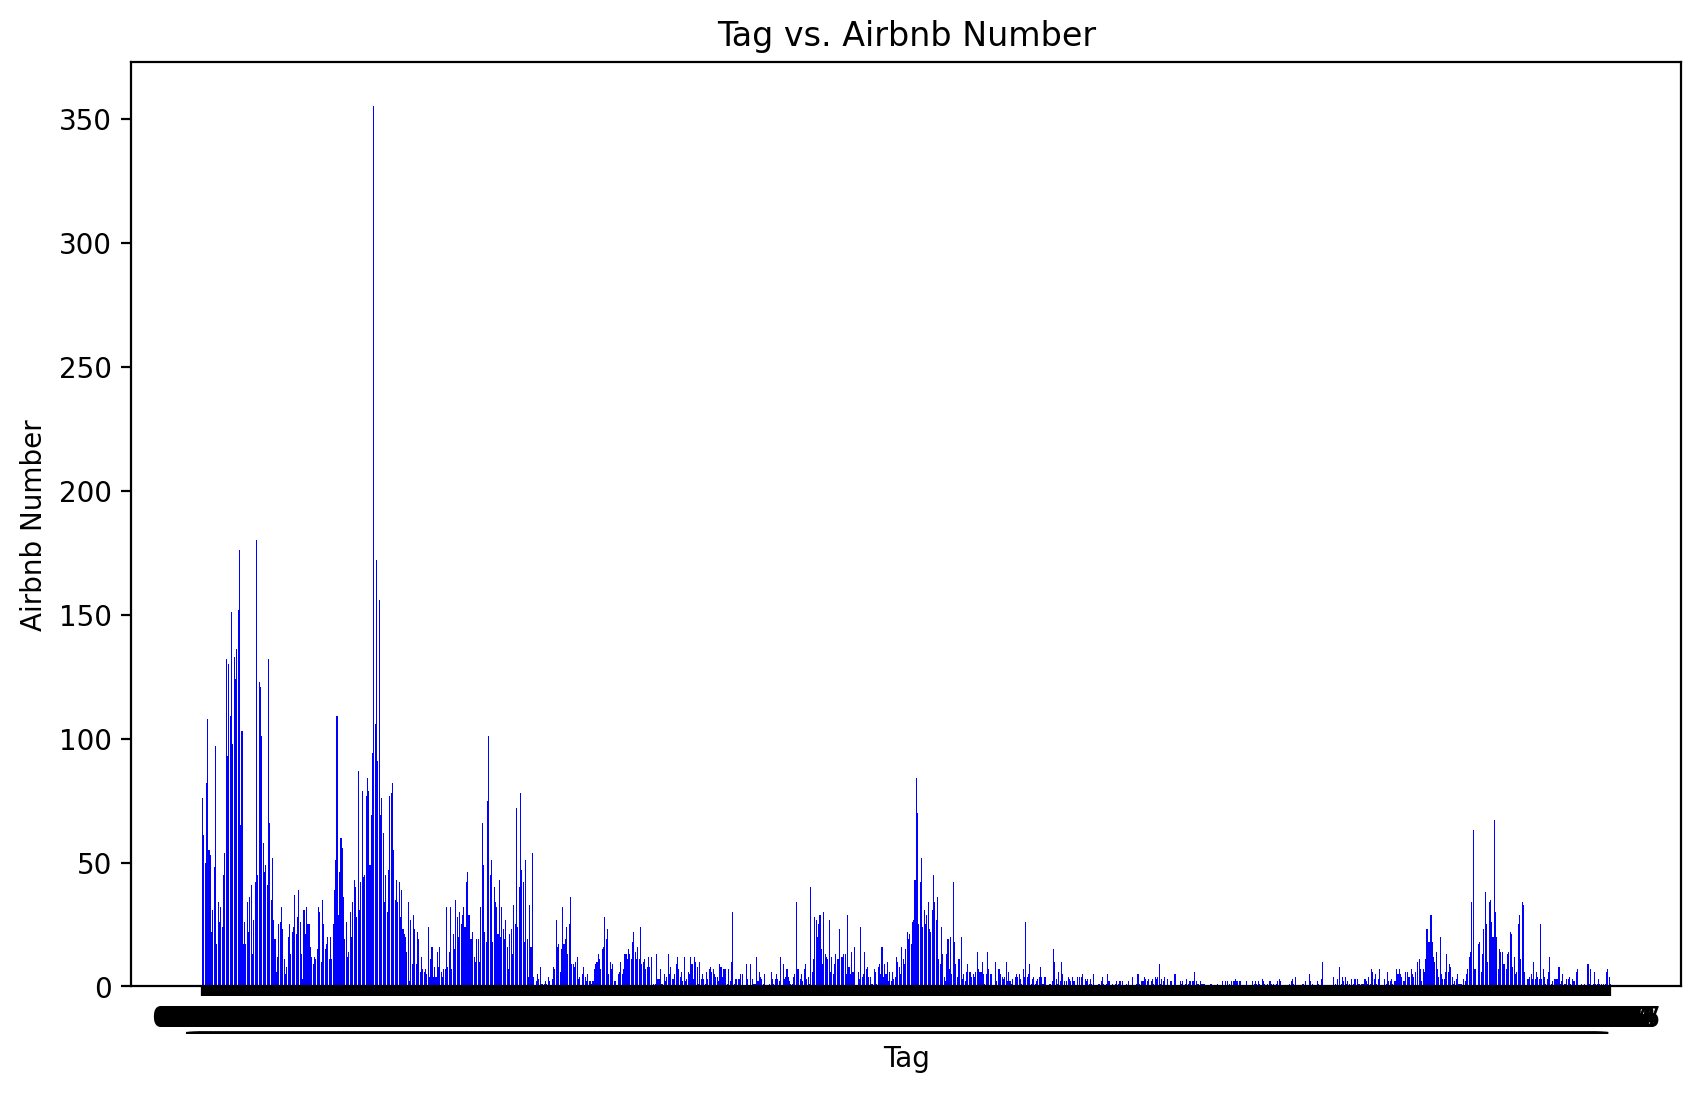

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(geo_info.index, geo_info["Airbnb_Number"], color="b")
plt.xlabel("Tag")
plt.ylabel("Airbnb Number")
plt.title("Tag vs. Airbnb Number")
plt.show()

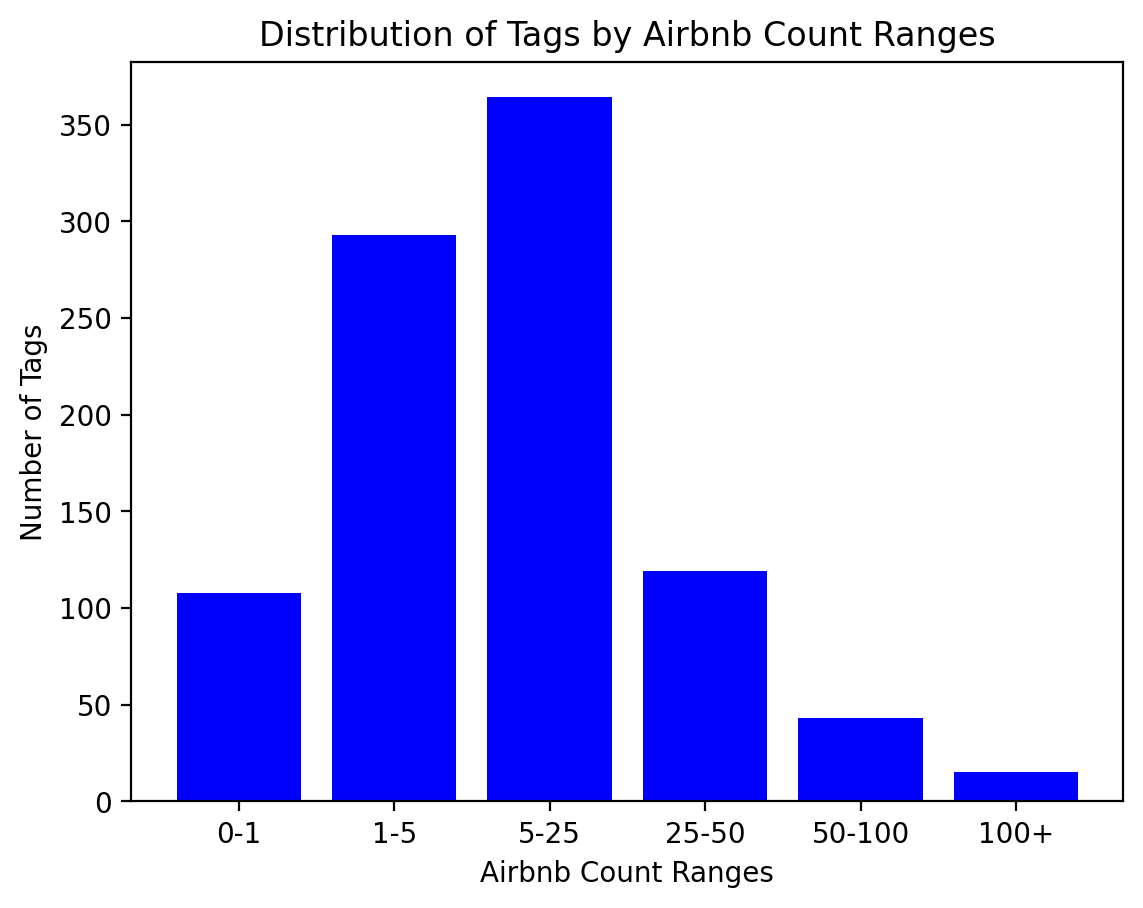

In [17]:
bins = [0, 1, 5, 25, 50, 100, 150]
labels = ["0-1", "1-5", "5-25", "25-50", "50-100", "100+"]

geo_info_rep = geo_info
geo_info_rep["Tag"] = geo_info_rep.index

geo_info_rep["Airbnb_Range"] = pd.cut(
    geo_info["Airbnb_Number"], bins=bins, labels=labels
)

tag_counts = geo_info.groupby("Airbnb_Range")["Tag"].count()

plt.bar(tag_counts.index, tag_counts.values, color="b")
plt.xlabel("Airbnb Count Ranges")
plt.ylabel("Number of Tags")
plt.title("Distribution of Tags by Airbnb Count Ranges")
plt.show()  # Display the plo

## NaNs

In [18]:
# define the colormap
cmap = plt.cm.Accent_r
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
# cmaplist[0] = (0.5, 0.5, 0.5, 1.0)
cmaplist[0] = "0.8"
# define the bins and normalize
bounds = np.linspace(0, 8, 9)
my_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

my_cmap = mpl.colors.LinearSegmentedColormap.from_list("Custom cmap", cmaplist, cmap.N)

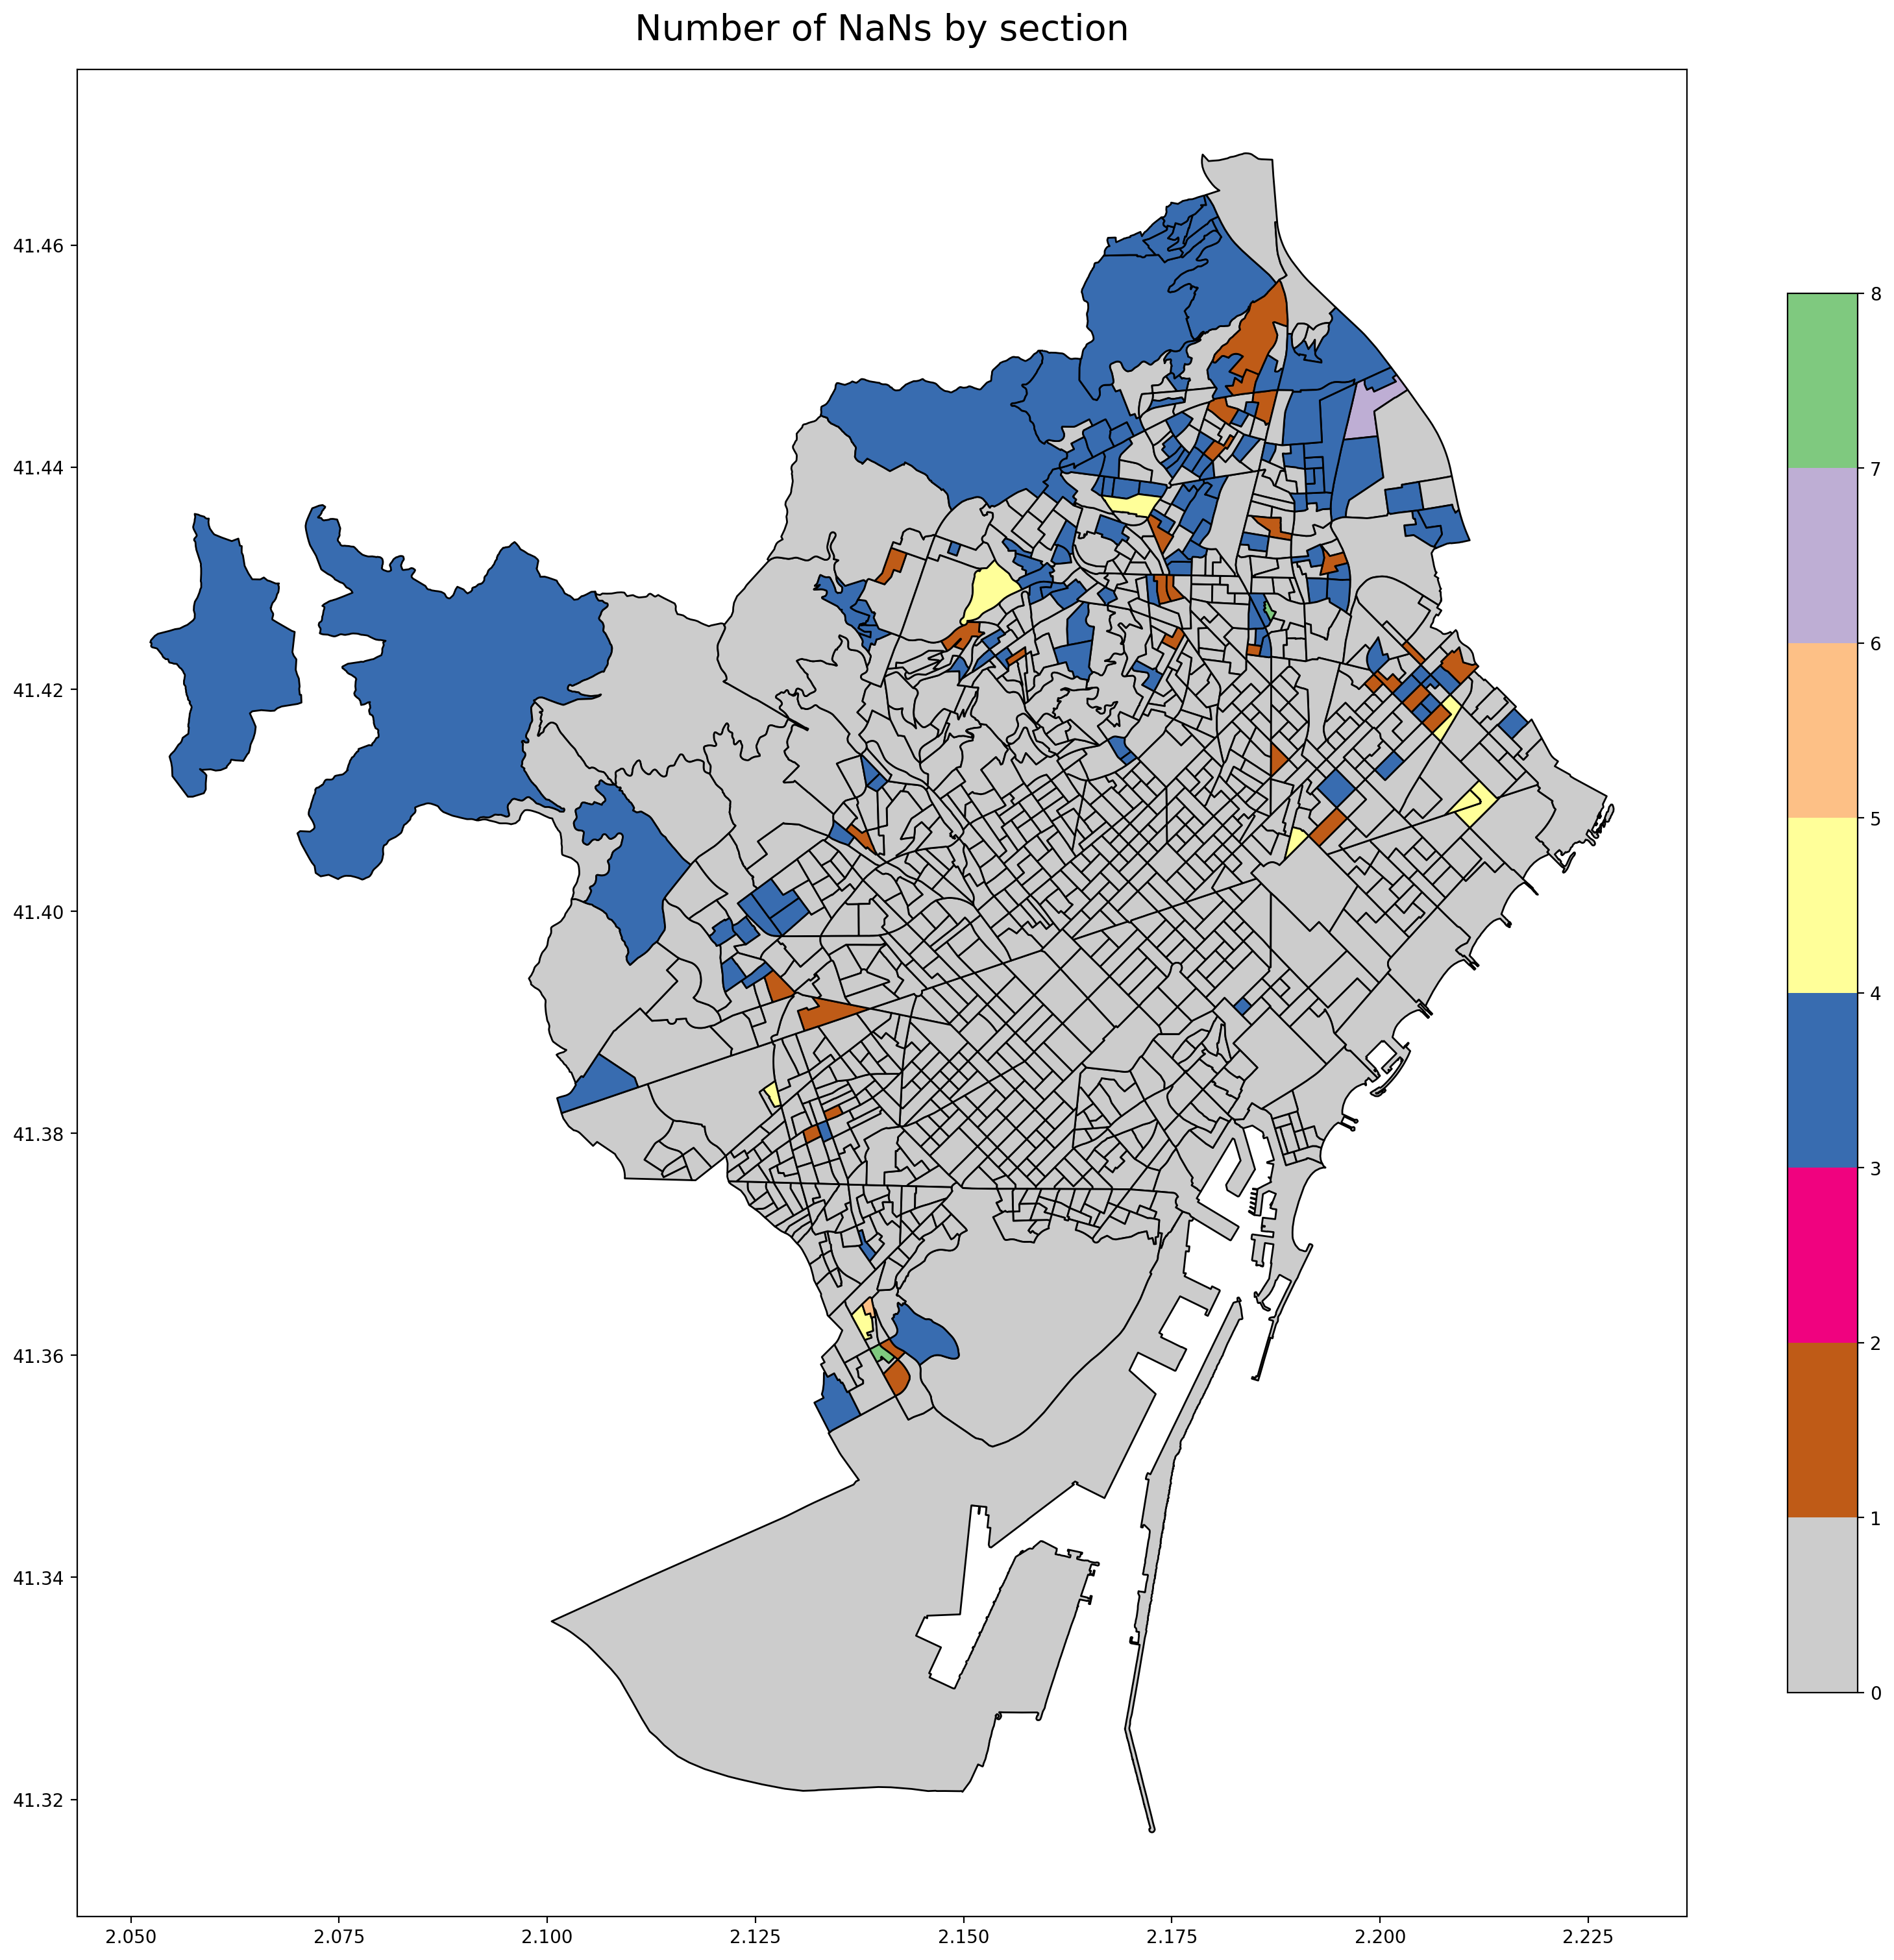

In [19]:
geo_nans["NaNs"] = pd.isnull(sect).sum(axis=1)

fig, ax = plt.subplots(figsize=(20, 20))

geo_nans.plot(
    ax=ax,
    column="NaNs",
    edgecolor="black",
    legend=True,
    norm=my_norm,
    cmap=my_cmap,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Number of NaNs by section", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_SVR / "nans.svg", format="svg")

plt.show()

# Moran’s Eigenvector Spatial Filtering (MESF) linear regression

Moran’s Eigenvector Spatial Filtering (MESF) is a spatial analysis technique used to model and adjust for spatial autocorrelation in linear regression models. Spatial autocorrelation refers to the correlation of a variable with itself through space. MESF utilizes eigenvectors derived from a spatial weights matrix to capture spatial structures and filter out spatial autocorrelation from the residuals of a regression model.

## Mathematical Derivation

The MESF approach involves several key steps and components. Here, we provide a basic mathematical overview:

1. **Spatial Weights Matrix (W)**:
   The spatial weights matrix, $W$, describes the spatial relationship among observations. For instance, $w_{ij}$ could be defined based on the geographical distance or contiguity (neighbor status). In this case, 3 different weight matrix computations are going to be used: 

   - Queen contiguity: it creates an edge between a CBG polygon and other CBGs that share a common boundary or vertices → it prioritizes adjacent CBGs instead of size/shape. 

   - k-nearest neighbor: it considers a specified k-number of closest CBG centroids based on Euclidean distances as neighbors → accounts for both shape and size, while ensuring an equal number of neighbors across all nodes. (k=4)

   - Gabriel graph: it also factors in shape and size but goes a step further by considering the relative location of other points in the study area. It creates an edge between two points when no other node falls within a circle that is constructed with the line segment that connects them as the diameter. More restrictive than other SWMs. 

2. **Standardization of W**:
   The matrix is typically row-standardized such that each element is divided by the row sum:
   $$
   w_{ij}^{*} = \frac{w_{ij}}{\sum_{j=1}^n w_{ij}}
   $$

3. **Moran's I**:
   Moran's I is a measure of spatial autocorrelation, defined as:
   $$
   I = \frac{n}{\sum_{i=1}^n \sum_{j=1}^n w_{ij}} \frac{\sum_{i=1}^n \sum_{j=1}^n w_{ij} (X_i - \bar{X})(X_j - \bar{X})}{\sum_{i=1}^n (X_i - \bar{X})^2}
   $$
   where $X_i$ is the value of the variable at location $i$, $\bar{X}$ is the mean of $X$, and $n$ is the number of observations.

4. **Eigenvectors of W**:
   The eigenvectors of the matrix $W$ (or a function of it, such as $I-W$) are calculated. These eigenvectors represent the spatial patterns inherent in the data.

5. **Incorporating Eigenvectors into Regression**:
   Significant eigenvectors are selected based on criteria such as their association with the response variable. These eigenvectors are then used as additional explanatory variables in the regression model to account for spatial autocorrelation:

   $$ Y = X\beta + E\lambda + \epsilon  $$

   $$ Y = \beta_0 + \beta_1X_1 + \cdots + \beta_kX_k + \gamma_1E_1 + \cdots + \gamma_mE_m + \epsilon  $$

   where $E_m$ are the Moran eigenvectors and $\gamma_m$ are their corresponding coefficients.

Incorporating Moran's Eigenvectors into a regression analysis helps in controlling for spatial autocorrelation, leading to more reliable and interpretable results.



In [20]:
pd.set_option("display.max_columns", None)
# print(X.head())
# print(geo_info.head())
geo_info.head()

geometry  \
Tag                                                         
01_001  POLYGON ((2.17575 41.37827, 2.17552 41.37865, ...   
01_002  POLYGON ((2.17510 41.37905, 2.17470 41.37951, ...   
01_003  POLYGON ((2.17220 41.37692, 2.17206 41.37696, ...   
01_004  POLYGON ((2.16962 41.37847, 2.16962 41.37847, ...   
01_005  POLYGON ((2.17366 41.38071, 2.17330 41.38113, ...   

                        centroid  Airbnb_Number     Tag Airbnb_Range  
Tag                                                                   
01_001  POINT (2.17722 41.37432)             76  01_001       50-100  
01_002  POINT (2.17391 41.37793)             61  01_002       50-100  
01_003  POINT (2.17199 41.37576)             50  01_003        25-50  
01_004  POINT (2.16924 41.37642)             82  01_004       50-100  
01_005  POINT (2.17277 41.37884)            108  01_005         100+

## Spatial Weight Matrices 

### Queen contiguity

In [21]:
def plot_spatial_weights(gdf, w, title):
    # Create a graph from the spatial weights matrix
    G = nx.Graph()
    for idx, neighbors in w.neighbors.items():
        for neighbor in neighbors:
            G.add_edge(idx, neighbor)

    # Get positions from centroids of the geodataframe
    pos = {
        idx: (gdf.geometry[idx].centroid.x, gdf.geometry[idx].centroid.y)
        for idx in G.nodes()
    }

    # Draw the network
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, node_size=50, node_color="blue", with_labels=False)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(title)
    plt.show()

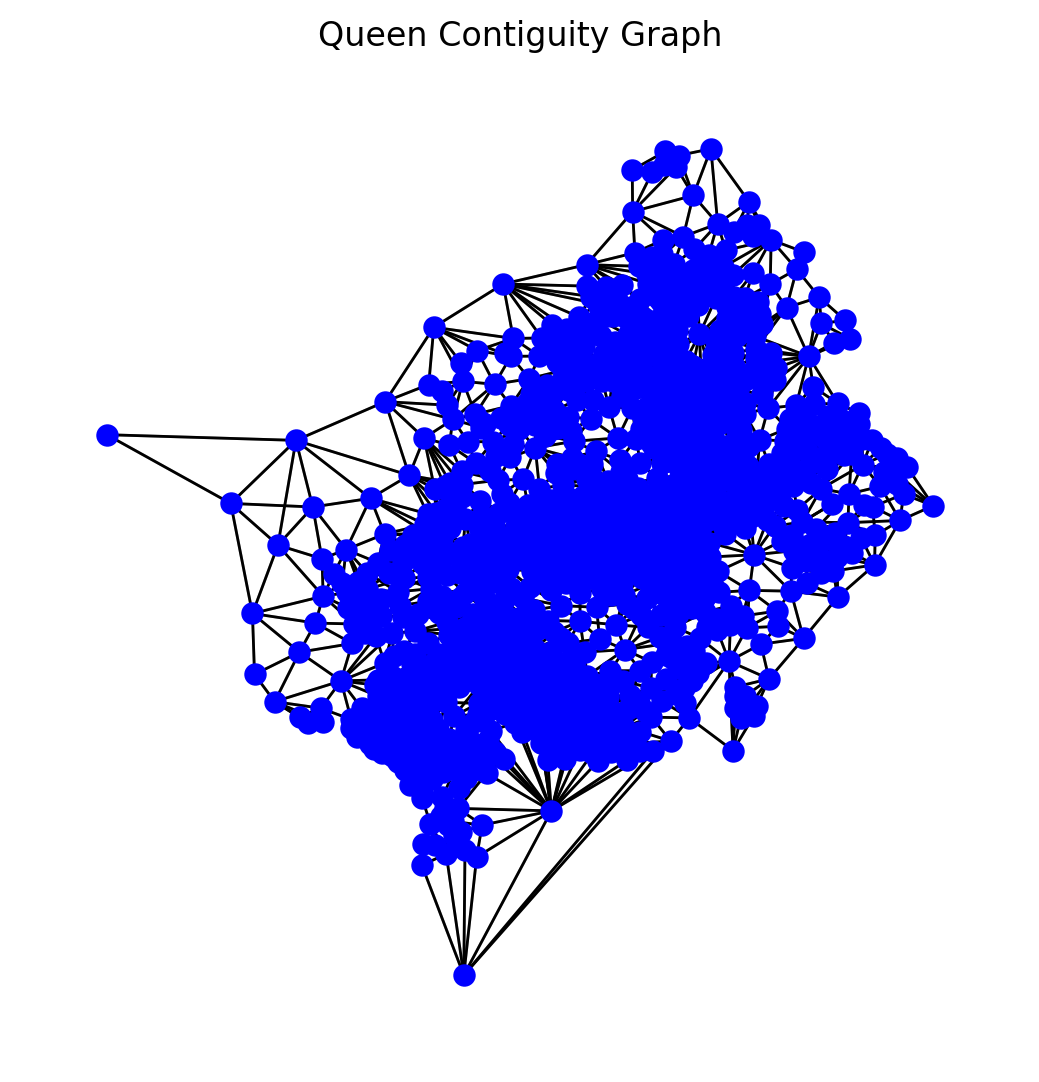

In [22]:
w_queen = Queen.from_dataframe(geo_info)
w_queen.transform = "R"  # row-standardizing the weight matrix

plot_spatial_weights(geo_info, w_queen, "Queen Contiguity Graph")

### K-nearest neighbor

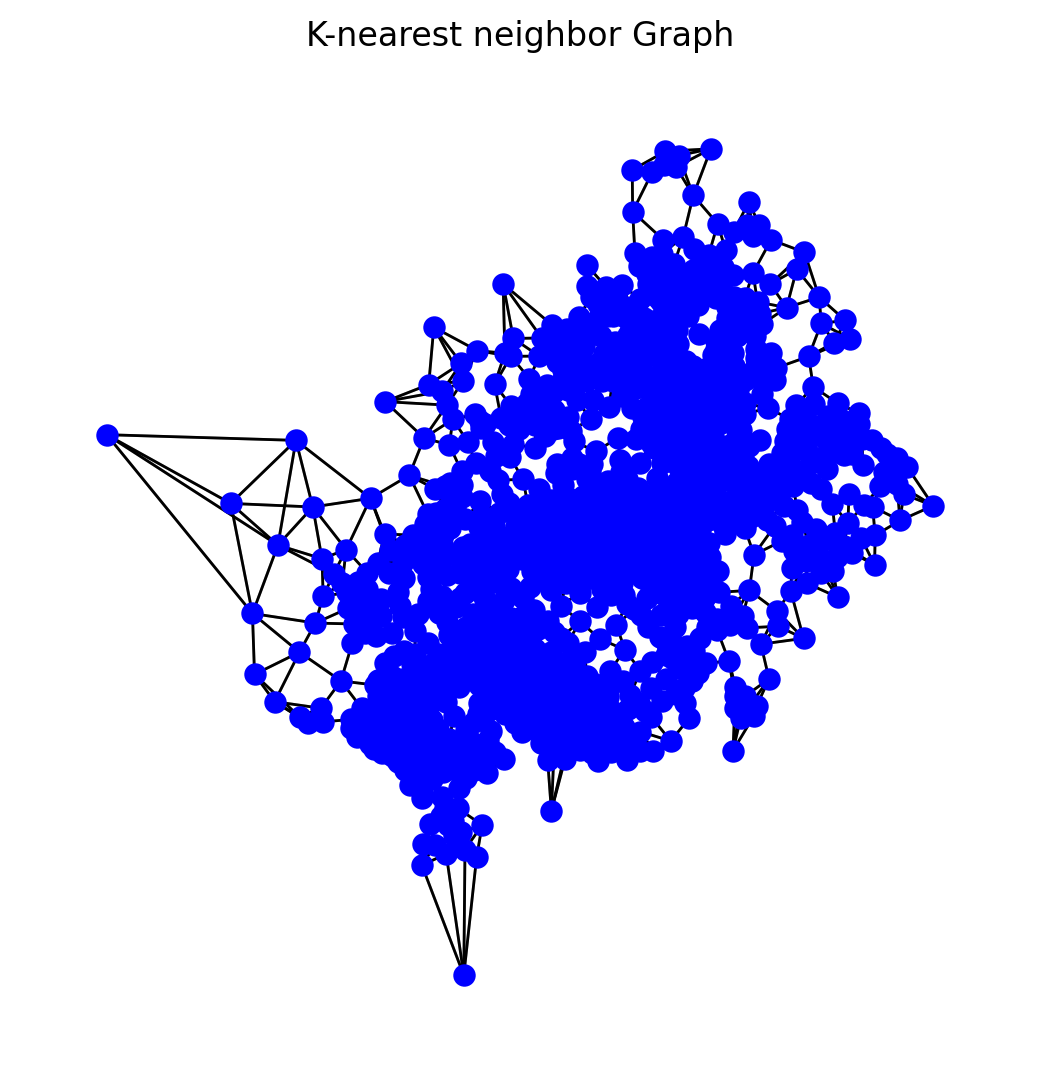

In [23]:
k = 4
w_knn = KNN.from_dataframe(geo_info, k=k)
w_knn.transform = "R"

plot_spatial_weights(geo_info, w_knn, "K-nearest neighbor Graph")

### Gabriel graph

In [24]:
geo_info.set_index("Tag", inplace=True)

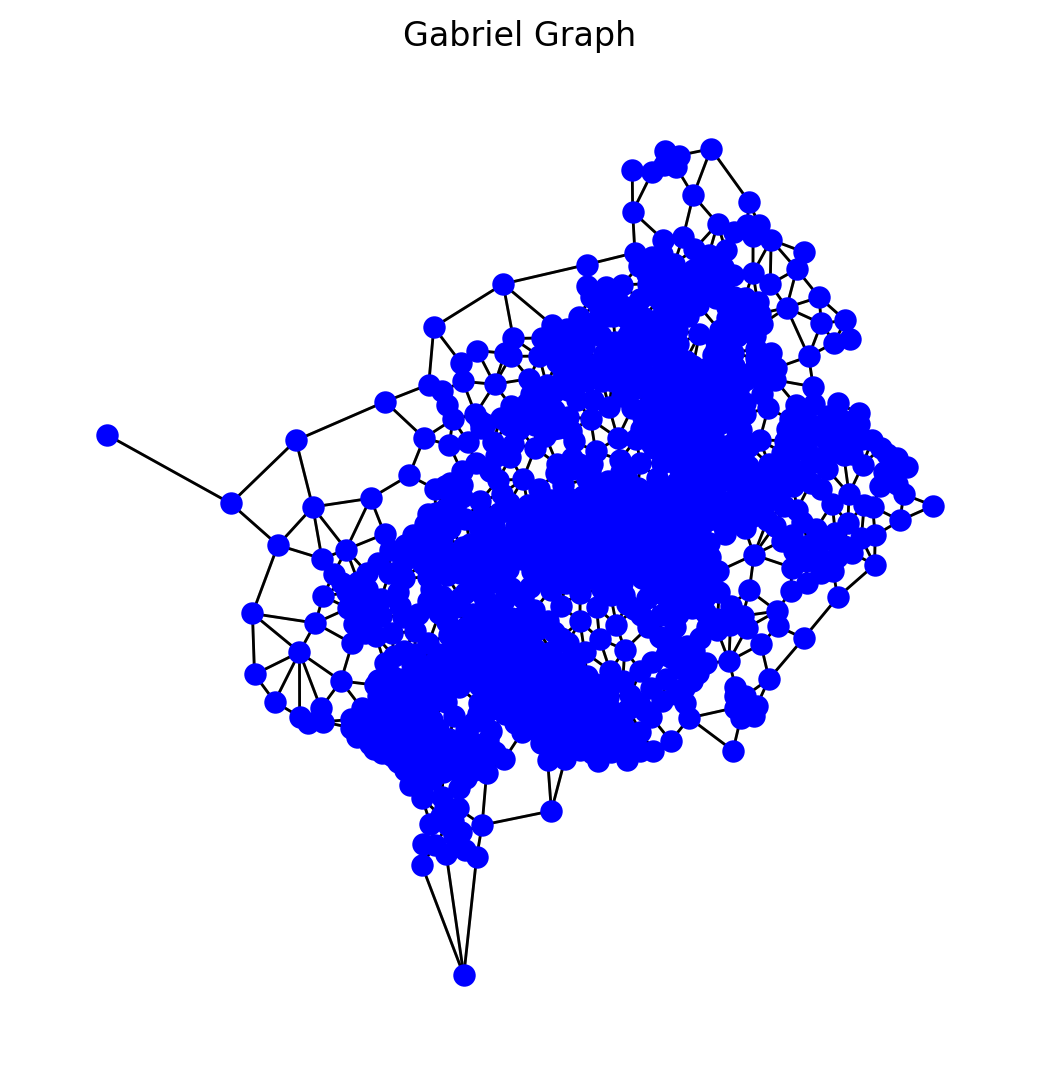

In [25]:
geo_info_points = geo_info.copy()
geo_info_points.set_geometry("centroid", inplace=True)
w_gabriel = Gabriel.from_dataframe(geo_info_points)
w_gabriel.transform = "R"

plot_spatial_weights(geo_info, w_gabriel, "Gabriel Graph")

In [26]:
w_gabriel.neighbors

{0: [1, 246, 28],
 1: [27, 0, 2, 4],
 2: [6, 1, 3, 245, 4, 246],
 3: [7, 242, 2, 223, 245],
 4: [1, 5, 2],
 5: [4, 26, 6, 18],
 6: [5, 18, 7, 2],
 7: [6, 8, 3, 9],
 8: [10, 223, 7, 9, 222],
 9: [8, 10, 12, 7],
 10: [8, 12, 9, 11, 222],
 11: [10, 219, 12, 14, 222],
 12: [14, 9, 11, 13, 10],
 13: [17, 12, 16, 18],
 14: [16, 218, 11, 15, 219, 12],
 15: [217, 14, 16, 218, 20],
 16: [13, 15, 17, 14],
 17: [19, 16, 20, 13],
 18: [13, 6, 19, 21, 5],
 19: [17, 21, 18, 130, 20],
 20: [130, 132, 15, 17, 19, 144],
 21: [130, 18, 22, 26, 19],
 22: [48, 21, 23],
 23: [45, 25, 27, 22, 26],
 24: [44, 45, 25, 29],
 25: [23, 27, 29, 24],
 26: [21, 23, 5, 27],
 27: [1, 23, 25, 26],
 28: [30, 38, 29, 0],
 29: [25, 24, 28],
 30: [28, 31],
 31: [36, 38, 37, 30, 32],
 32: [36, 31, 33],
 33: [32, 34, 36],
 34: [974, 975, 33, 35],
 35: [40, 37, 39, 34, 36],
 36: [32, 31, 33, 35, 37],
 37: [35, 39, 36, 38, 31],
 38: [31, 37, 28, 39],
 39: [38, 40, 35, 37],
 40: [41, 35, 39],
 41: [42, 974, 967, 971, 40, 968],


In [27]:
# def plot_geographical_sections_with_graph(gdf, w, title):
#     # Plot the geographical polygons
#     fig, ax = plt.subplots(figsize=(12, 12))
#     gdf.plot(ax=ax, color="lightblue", edgecolor="black")

#     # Create a graph from the spatial weights matrix
#     G = nx.Graph()
#     pos = {}
#     for idx, row in gdf.iterrows():
#         G.add_node(idx)
#         pos[idx] = (
#             row["centroid"].x,
#             row["centroid"].y,
#         )  # Using centroid for node positions
#         for neighbor in w.neighbors[idx]:
#             G.add_edge(idx, neighbor)

#     # Draw the nodes
#     nx.draw_networkx_nodes(G, pos, node_size=50, node_color="red", ax=ax)

#     # Draw the edges
#     nx.draw_networkx_edges(G, pos, edge_color="gray", style="dashed", ax=ax)

#     # Set plot title and show
#     plt.title(title)
#     plt.gca().set_aspect("equal", adjustable="datalim")
#     plt.show()


# plot_geographical_sections_with_graph(
#     geo_info, w_gabriel, "Gabriel Graph with Geographical Sections"
# )

## Moran's Eigenvectors

In [29]:
from esda.moran import Moran
from scipy.linalg import eigh

# MORAN's I
moran = Moran(y.values, w_queen)
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")

# Eigenvectors (I-W)
w_matrix = w_queen.full()[0]  # full matrix form of w
n = w_matrix.shape[0]
identity_matrix = np.eye(n)
laplacian = identity_matrix - w_matrix  # Laplacian matrix (I - W)
eigenvalues, eigenvectors = eigh(laplacian)

num_eigenvectors = 5  # choose number of eigenvectors
significant_eigenvectors = eigenvectors[:, :num_eigenvectors]

print(significant_eigenvectors)

Moran's I: 0.7607854641638696, p-value: 0.001
[[ 4.13015373e-02  7.41249075e-04  2.41492136e-02 -3.58474294e-03
   1.10883628e-02]
 [ 1.70330494e-02  1.11518286e-03  3.53041009e-02 -6.39928653e-03
   1.54234584e-02]
 [ 2.14421215e-02  5.95946314e-04  2.01184715e-02 -3.39266123e-03
   9.18176277e-03]
 ...
 [ 2.98001011e-04  1.77937166e-02  7.81936044e-02  1.13717952e-02
  -2.17418581e-02]
 [ 3.12496299e-04  1.89692532e-02  8.20454904e-02  1.21042100e-02
  -2.31634190e-02]
 [ 9.33632956e-05  1.83778323e-02  3.38328477e-02  1.20868733e-02
  -2.36041919e-02]]


In [30]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh


def compute_morans_eigenvectors(w, num_eigs=10):
    # Convert the weights matrix to a sparse format
    w_matrix = csr_matrix(w.full()[0])
    # Compute the largest eigenvalues and corresponding eigenvectors
    # Adjust 'num_eigs' to the number of eigenvectors you want (it should be less than the number of areas)
    eigenvalues, eigenvectors = eigsh(
        w_matrix, k=num_eigs, which="LM"
    )  # 'LM' means largest magnitude
    return eigenvectors


eigenvectors_queen = compute_morans_eigenvectors(w_queen)
eigenvectors_knn = compute_morans_eigenvectors(w_knn)
eigenvectors_gabriel = compute_morans_eigenvectors(w_gabriel)

print(eigenvectors_queen)

[[ 0.03746997  0.00028206  0.01413278 ...  0.03465798 -0.0247176
  -0.03116565]
 [ 0.03543916 -0.01739829  0.00623985 ...  0.03893086 -0.02035225
  -0.03130472]
 [ 0.03224857 -0.00850747  0.01774832 ...  0.03725867 -0.02406436
  -0.03039571]
 ...
 [-0.04383577  0.04197313 -0.02938375 ...  0.06047957  0.02720662
  -0.02975078]
 [-0.04191874  0.04017537 -0.02807464 ...  0.06094523  0.0282007
  -0.02927038]
 [-0.03606773  0.03565491  0.00698328 ...  0.05354429  0.03584433
  -0.03073289]]


## Regression Model 

In [31]:
X.head()

Distance_Center  POI_Daily_Food  POI_Daily_Others  \
Tag                                                         
01_001         1.532922               6                 1   
01_002         1.060772               3                 2   
01_003         1.262231               9                 3   
01_004         1.180517              13                 4   
01_005         0.937494              20                 4   

        POI_House_Equipment  POI_Clothing  POI_Culture  POI_Vehicles  \
Tag                                                                    
01_001                    0             0            2             0   
01_002                    1             2            1             0   
01_003                    1             2            3             0   
01_004                    8             2            5             0   
01_005                    2             2           38             0   

        POI_State_Agents  POI_Education  POI_Finances  POI_Restaurants_Hotels  \
Tag                                                                             
01_001                 0              4             0                      33   
01_002                 0              2             0                      19   
01_003                 0              5             2                      20   
01_004                 2              3             3                      36   
01_005                 0              0             1                      42   

        POI_Health  POI_Souvenirs_Thrift_Store  POI_Car_Parks  POI_Esthetics  \
Tag                                                                            
01_001           2                           8              1              1   
01_002           0                           3              0              5   
01_003           3                           1              2              3   
01_004           1                           3              1              9   
01_005           1                          15              1             11   

        POI_Sports  POI_Religion  POI_Administration  \
Tag                                                    
01_001           1             1                   4   
01_002           0             0                   0   
01_003           1             0                   1   
01_004           1             2                   3   
01_005           0             0                   2   

        Percentage_Gender_Female  Percentage_Age_0_14  Percentage_Age_15_24  \
Tag                                                                           
01_001                  0.464203             0.123172              0.087760   
01_002                  0.486604             0.101376              0.126720   
01_003                  0.458248             0.200466              0.130637   
01_004                  0.450767             0.122317              0.111414   
01_005                  0.460146             0.118053              0.112452   

        Percentage_Age_40_64  Percentage_Age_65_Plus  Household  \
Tag                                                               
01_001              0.318707                0.143957       2.52   
01_002              0.281680                0.133961       2.60   
01_003              0.291824                0.108525       3.23   
01_004              0.329472                0.100170       2.65   
01_005              0.326583                0.126239       2.45   

        Education_None  Education_Primary_School  Education_Middle_School  \
Tag                                                                         
01_001        0.011474                  0.211827                 0.248897   
01_002        0.023200                  0.220800                 0.251200   
01_003        0.012806                  0.296744                 0.256129   
01_004        0.010937                  0.227734                 0.246875   
01_005        0.015648                  0.246455                 0.

In [32]:
X_variables = X.reset_index().drop(columns="Tag")
# adding eigenvectors to predictors
eigenvectors_df = pd.DataFrame(eigenvectors_queen)
eigenvectors_df.columns = eigenvectors_df.columns.astype(
    str
)  # in order to avoid problems when predicting
X_enhanced = pd.concat([X_variables, pd.DataFrame(eigenvectors_queen)], axis=1)

print(f"Shape of input matrix: {X_enhanced.shape}")

X_train = X_enhanced.to_numpy()
y_train = y.to_numpy()

imputer = KNNImputer()
X_train = imputer.fit_transform(X_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

model = LinearRegression().fit(X_train, y)

Shape of input matrix: (1068, 94)


## Visualization and Evaluation 

### Model evaluation

In [38]:
y_truth = pd.Series(y, name="True Data")  # real y values:

y_pred = model.predict(X_train)  # predicted values over the testing set
y_pred = pd.Series(
    y_pred, index=geo_info.index, name="MESF"
)  # relating the pred values with the geographical tags

mse = mean_squared_error(y, y_pred)
print(f"Mean Squared Error: {mse}")

residuals = y - y_pred

Mean Squared Error: 115.16328874625627


#### Spatial Autocorrelation handling

##### Moran's I on residuals 

In [44]:
def calculate_morans_i(residuals, geo_info):
    w = Queen.from_dataframe(geo_info)
    w.transform = "R"
    moran = Moran(residuals, w)
    return moran.I, moran.p_sim

moran = calculate_morans_i(residuals, geo_info)
print(f"Moran's I: {moran[0]}, p-value: {moran[1]}")

Moran's I: 0.10715603112706117, p-value: 0.001


##### Cross validation with training and test sets for different sections

In [ ]:
# Something like this:

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Example of spatially aware splitting 
# train_idx = geo_df[geo_df['cluster_id'] % 5 != 0].index
# test_idx = geo_df[geo_df['cluster_id'] % 5 == 0].index

# X_train, X_test = X.loc[train_idx], X.loc[test_idx]
# y_train, y_test = y[train_idx], y[test_idx]

##### Residuals visualization 

In [ ]:
# def plot_residuals(gdf, residuals, title):
#     gdf['residuals'] = residuals
#     fig, ax = plt.subplots(figsize=(10, 10))
#     gdf.plot(column='residuals', ax=ax, legend=True, cmap='coolwarm')
#     plt.title(title)
#     plt.show()

# plot_residuals(geo_df, lr_residuals, 'Linear Regression Residuals')
# plot_residuals(geo_df, gwr_residuals, 'GWR Residuals')

##### Other metrics

AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion), R-squared, or Adjusted R-squared

#### Performance (Accuracy - Training) Representation

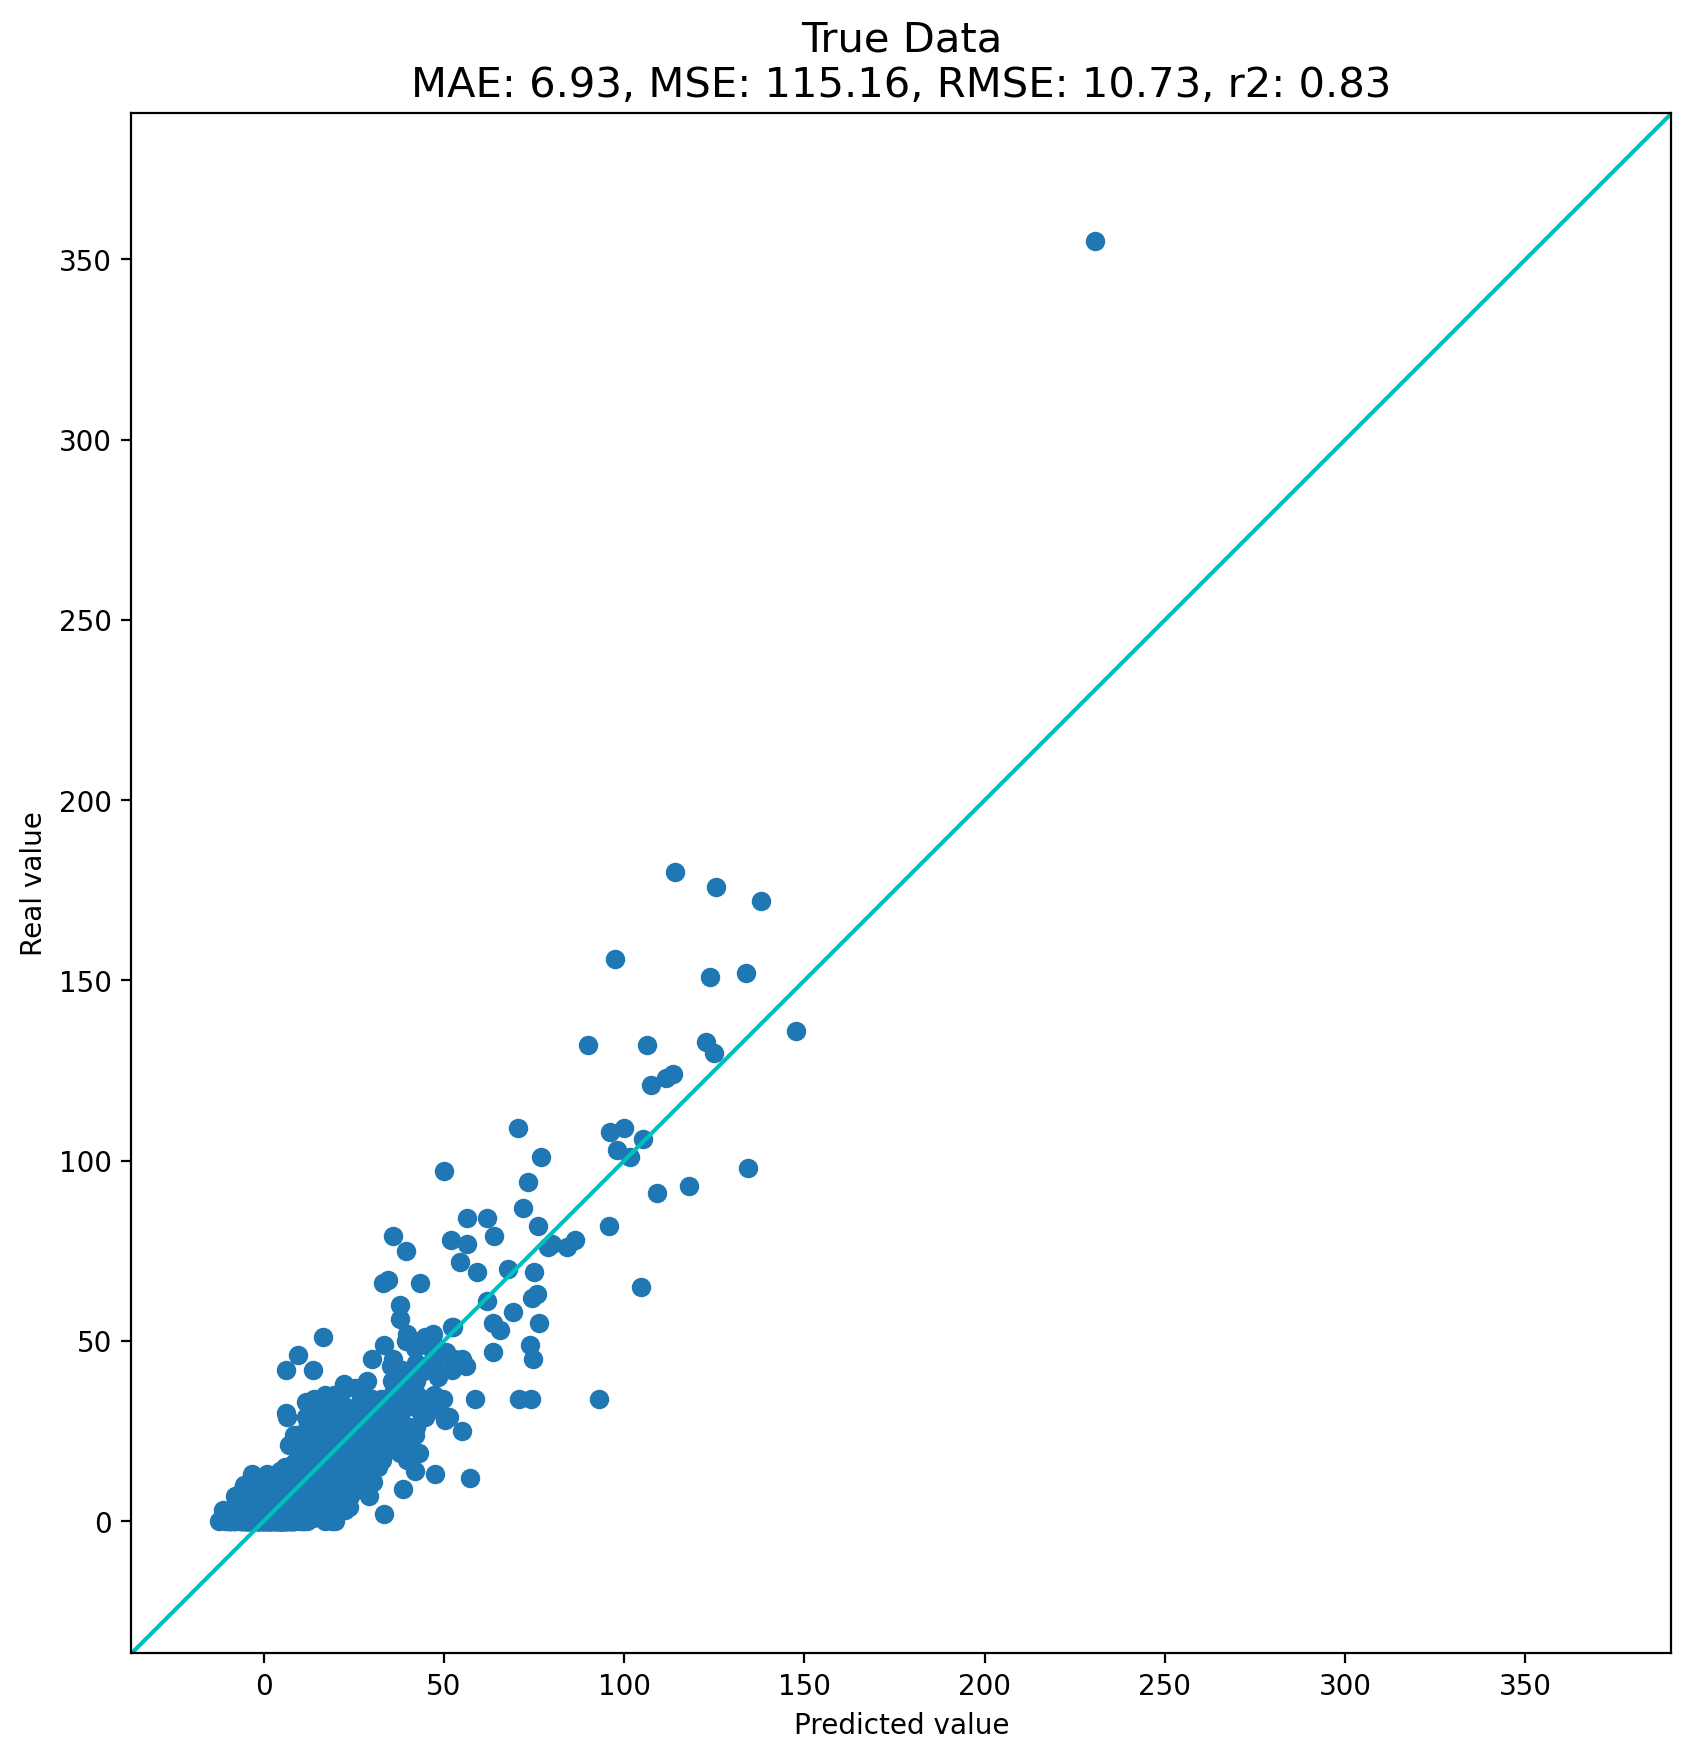

In [34]:
pa_svr = PredictedAccuracy(y_truth, y_pred)
pa_svr.plot_scatter(save_fig=SAVE_FIGS, root_name=DIR_SVR / "svr_model")

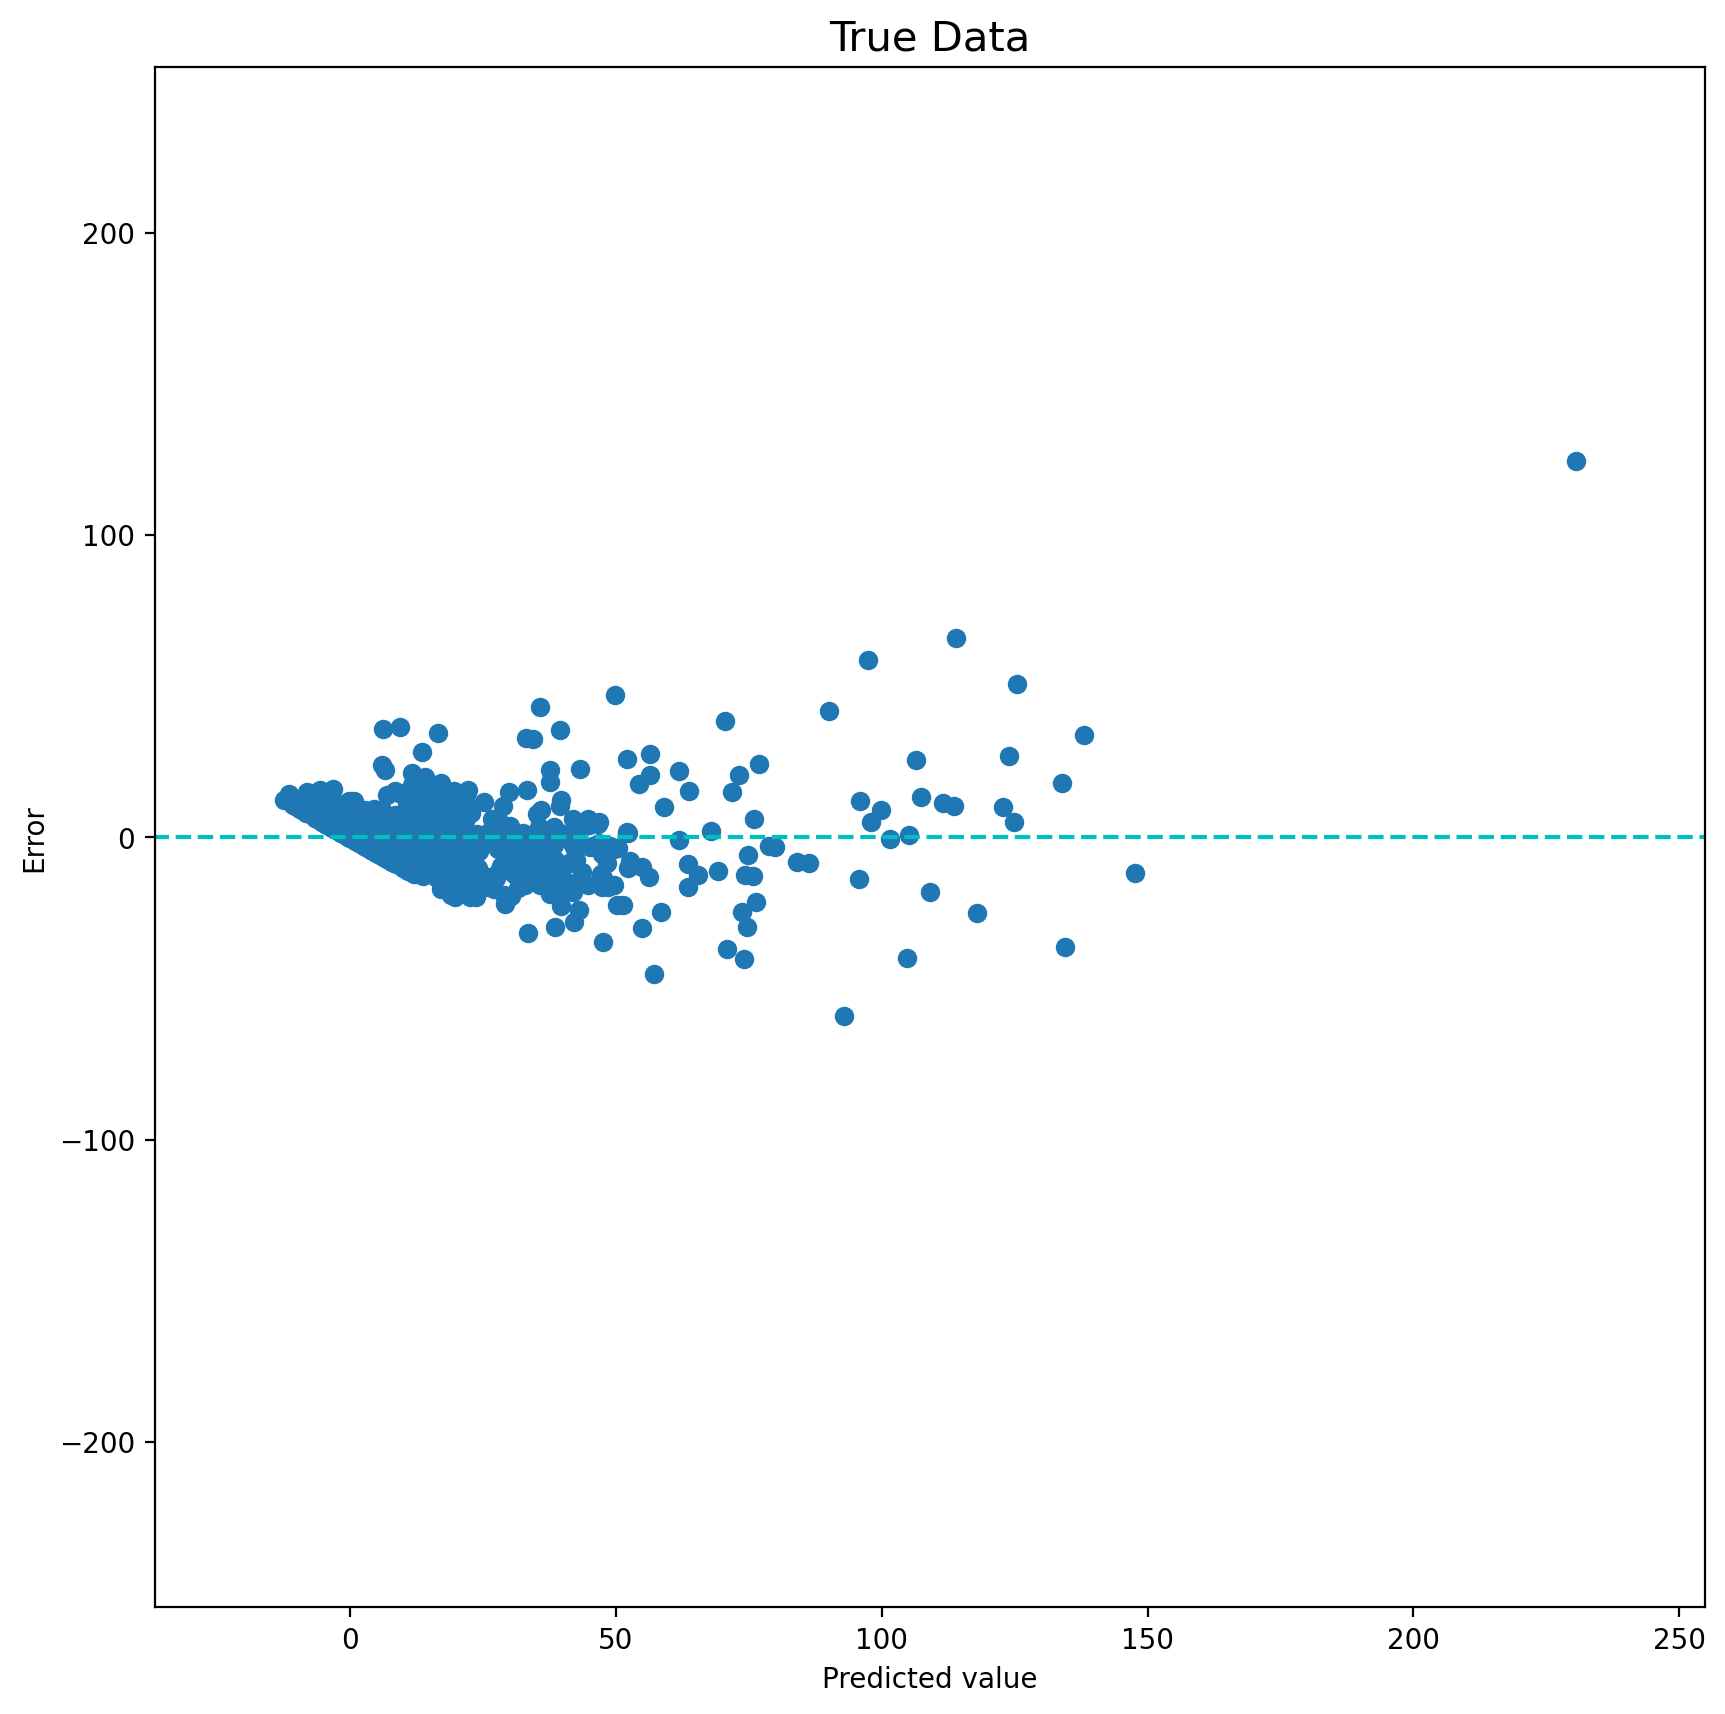

In [35]:
pa_svr.plot_errors(save_fig=SAVE_FIGS, root_name=DIR_SVR / "svr_model")

#### Relative errors

In [36]:
# adding the error to the geographical information
geo_info["Chosen_Error"] = (
    2 * (y_truth.values - y_pred.values) / (abs(y_truth.values) + abs(y_pred.values))
)

col_lim = max(
    abs(geo_info["Chosen_Error"].min()), abs(geo_info["Chosen_Error"].max())
)  # maximum error value

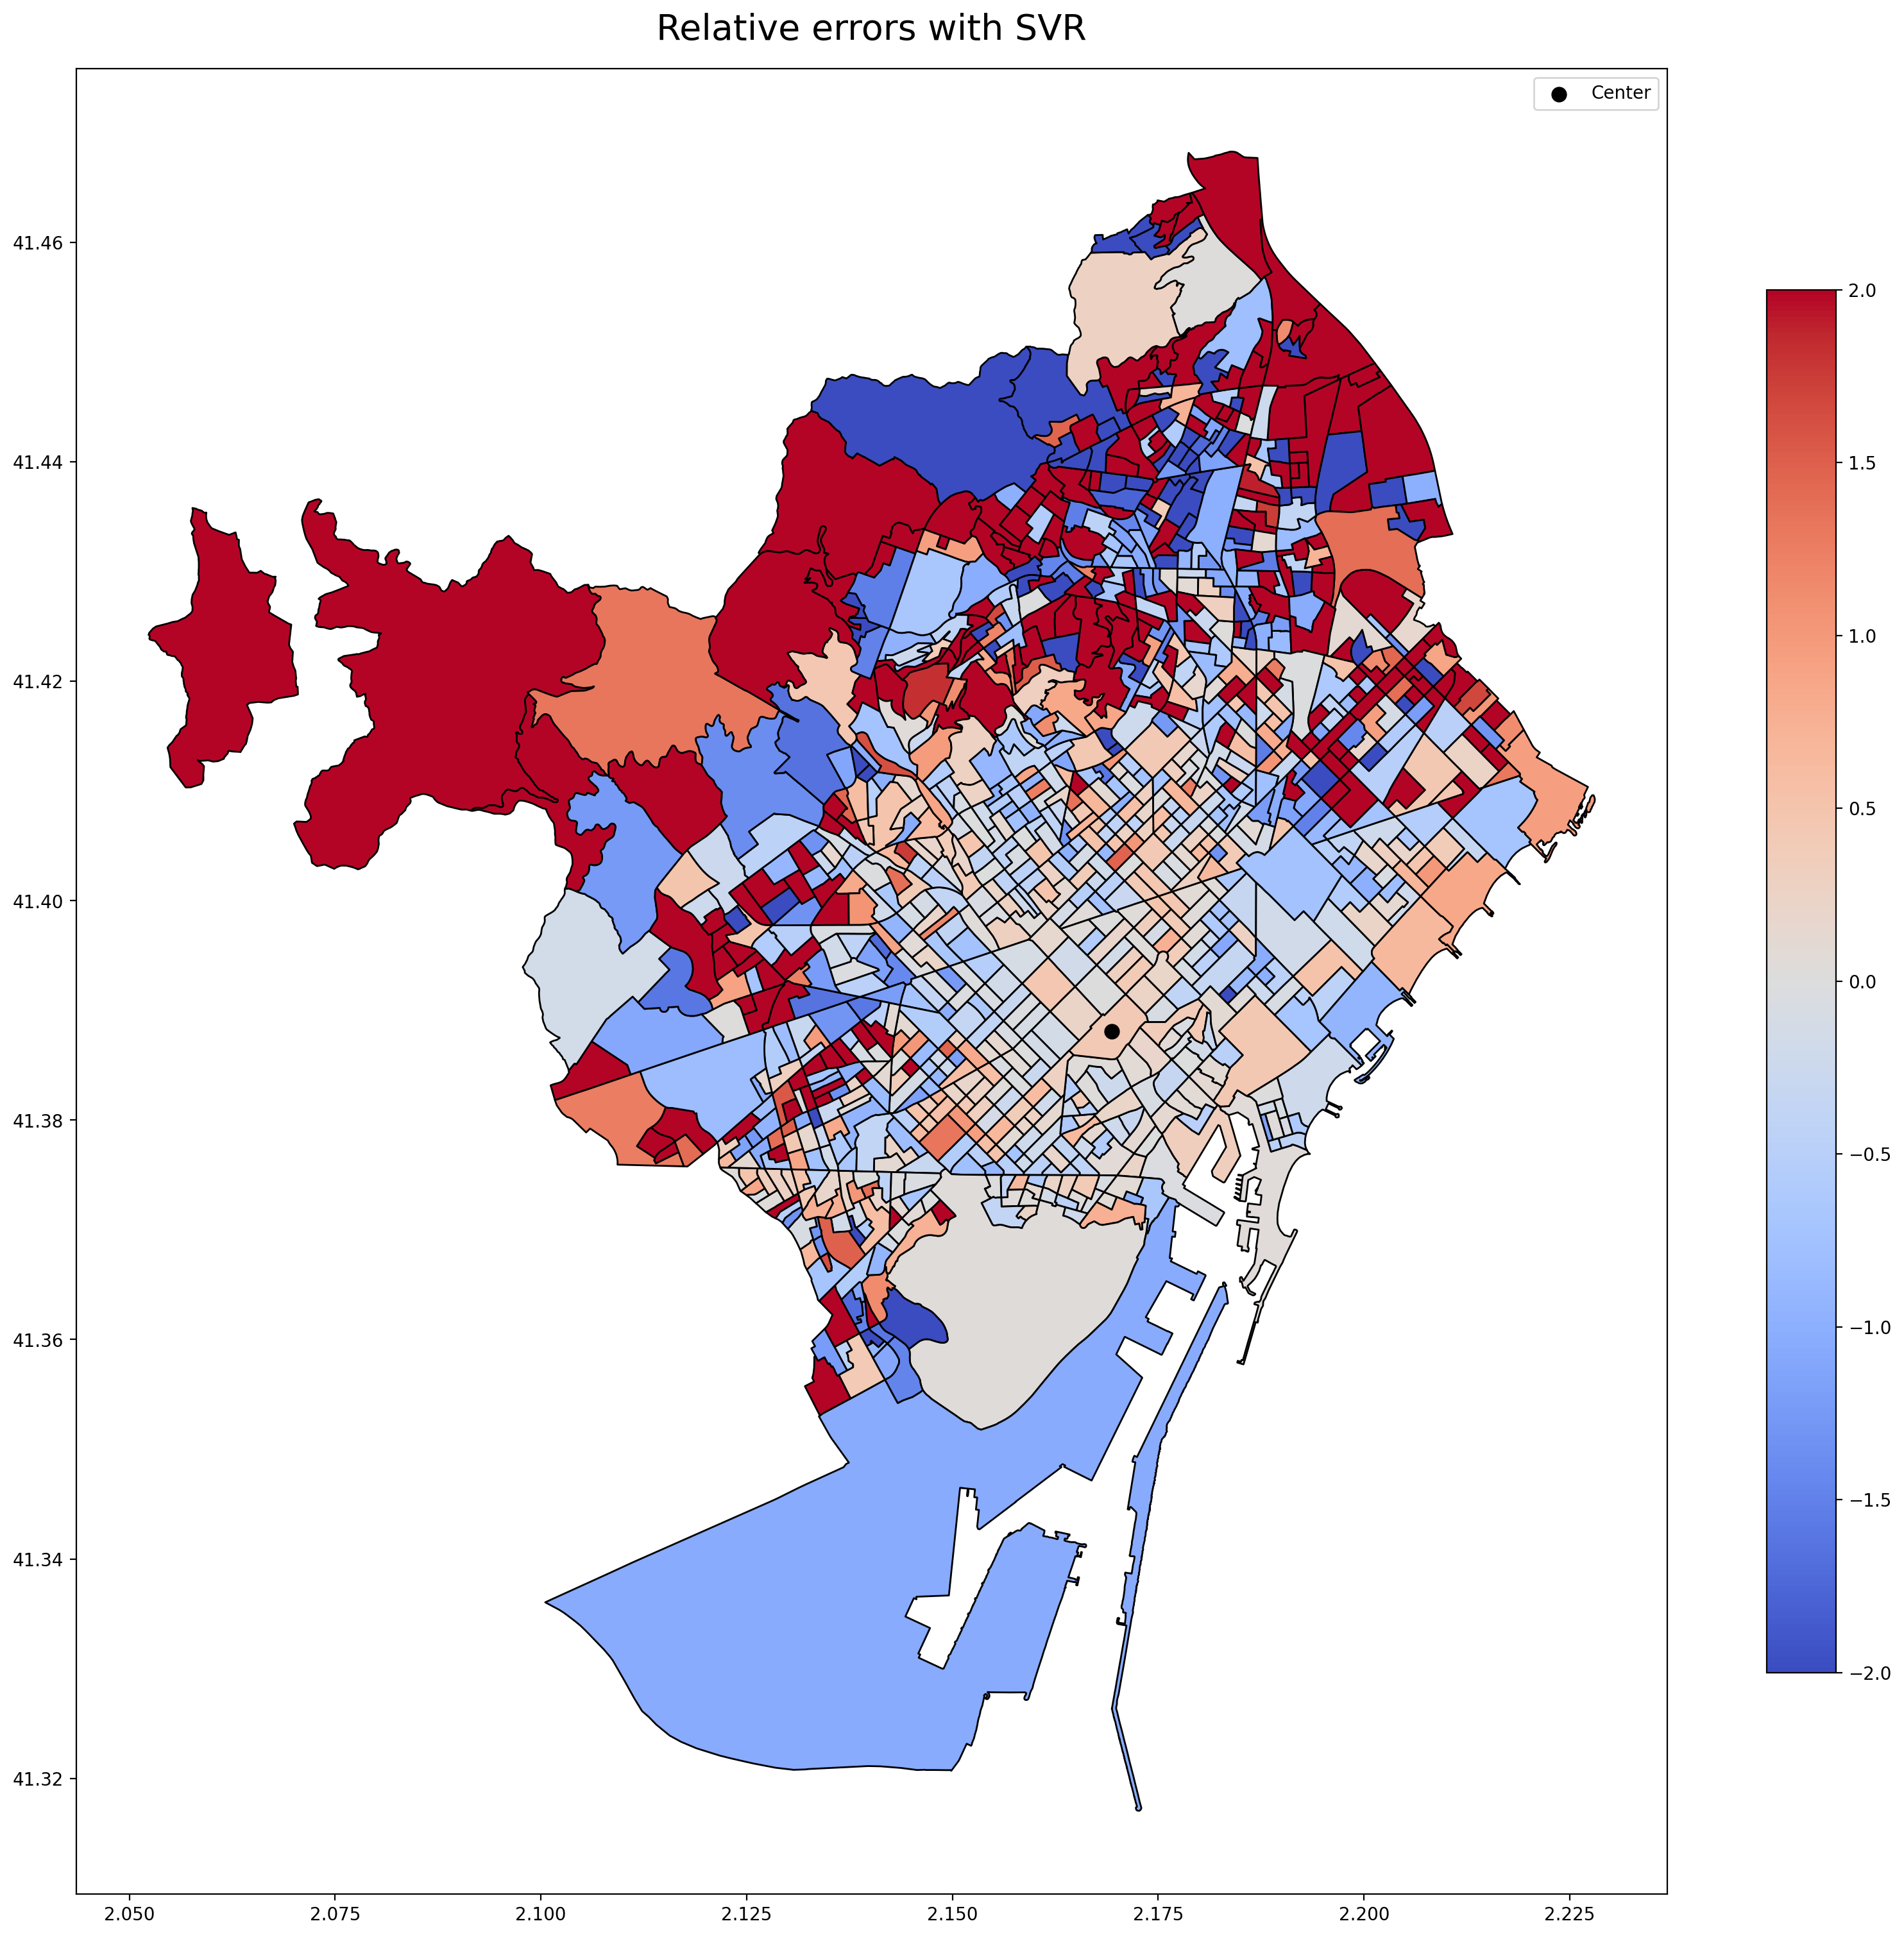

In [37]:
fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    edgecolor="black",
    column="Chosen_Error",
    legend=True,
    vmin=-col_lim,
    vmax=col_lim,
    cmap="coolwarm",
    legend_kwds={"shrink": 0.7},
)

geo_info[geo_info.index == id_max_airbnb].centroid.plot(
    ax=ax, color="black", markersize=60, label="Center"
)

plt.legend()

ax.set_title("Relative errors with SVR", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_SVR / "relative_errors.svg", format="svg")

plt.show()

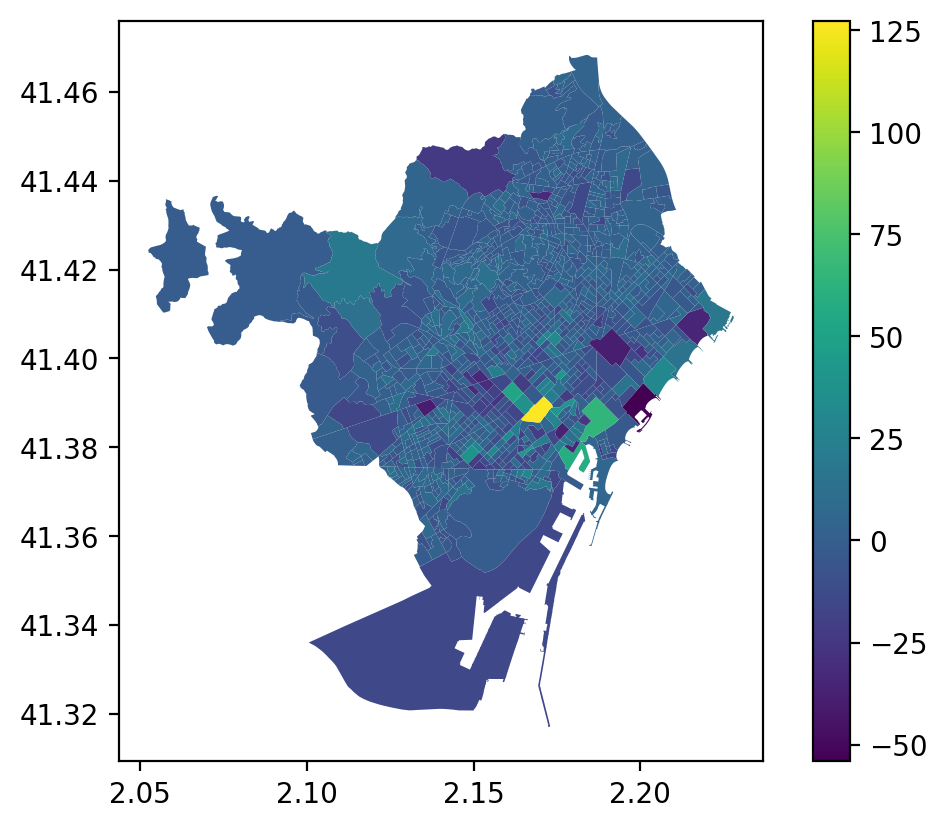

In [46]:
# print(model.coef_)

# Visualize the geographical distribution of residuals or fitted values
geo_info["residuals"] = y - model.predict(X_train)
geo_info.plot(column="residuals", legend=True)
plt.show()